In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as scl
from scipy.integrate import odeint

/Users/fkn1/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Simulation Routine
We set up a simple numerical integrator for 1d SDEs (first order Euler scheme)

In [22]:
# This function realizes the standard Euler scheme
# for a stochastic differential equation in 1d:
def Euler_Scheme(x0, b, sigma, dt, ntraj, m):
    # Prepare output:
    y = np.zeros((ntraj, m))
    y[:, 0] = x0
    # Initialize at x0:
    x = x0
    # Integrate:
    for kk in range(1, m):
        # Update:
        xn = x + dt * b(x) + sigma(x) * np.sqrt(dt)* np.random.randn(ntraj)
        # Update current state:
        y[:, kk] = xn
        x = xn
    return y

### Definition of Linear SDE
Define callable functions for drift and diffusion of linear SDE in 1d

In [23]:
# Drift
def _b(x):
    return -x
# Diffusion:
def _sigma(x):
    return np.sqrt(2)

### Evolution of Densities:

First, use the above function to produce 1000 simulations, each comprising discrete 1000 steps, at integration time step 1e-3, starting at $x_0 = 2$. Produce a histogram of the data after [10, 20, 50, 100, 200, 500] steps.
Then, repeat the experiment, but draw the initial condition from a standard normal distribution.

In [24]:
# Settings:
m = 1000
dt = 1e-2
ntraj = 10000

# Initial conditions:
x0 = 2.0 * np.ones(ntraj)
X = Euler_Scheme(x0, _b, _sigma, dt, ntraj, m)

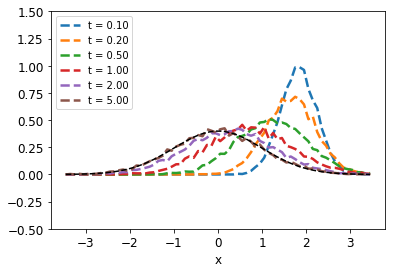

In [25]:
# Time instances to be used for histogramming:
t_vec = np.array([10, 20, 50, 100, 200, 500])
# Bins for histogram:
xe = np.arange(-3.5, 3.51, 0.1)
xc = 0.5 * (xe[1:] + xe[:-1])

# Histogram the data at different time instances:
plt.figure()

qq = 0
for t in t_vec:
    h, _ = np.histogram(X[:, t-1], bins=xe, density=True)
    plt.plot(xc, h, "--", linewidth=2.5, label="t = %.2f"%(dt * (t)))
plt.plot(xc, (1.0/np.sqrt(2*np.pi))*np.exp(-0.5 * xc**2), "k--")
plt.xlabel("x", fontsize=12)
plt.tick_params(labelsize=12)
plt.ylim([-.5, 1.5])
plt.legend(loc=2)

### Estimating the Koopman Operator

First, write a function to compute a matrix approximation for the Koopman operator. Inputs should be the raw data, the time shifted raw data, a callable function to realize the basis set:

In [6]:
def koopman_matrix(X, Y, psi):
    # Evaluate basis set on full data:
    PX = psi(X)
    PY = psi(Y)
    # Compute Koopman matrix:
    K = np.dot(scl.pinv(np.dot(PX, PX.T)), np.dot(PX, PY.T))
    return K

Produce 20,000 pairs $(x_l, y_l)$ by drawing $x_l$ from the invariant measure of our linear SDE. Compute each $y_l$ by running the dynamics over time $t = 0.1$ (10 discrete time steps). Then, estimate the Koopman matrix for the monomial basis of degree 5.

In [7]:
# Produce the data:
ntraj = 20000
X = np.random.randn(ntraj)
m = 10
Y = Euler_Scheme(X, _b, _sigma, dt, ntraj, m)[:, -1]

In [8]:
# Define basis set:
n = 5
def _psi(x):
    m = x.shape[0]
    px = np.zeros((n, m))
    for ll in range(n):
        px[ll, :] = x**ll
    return px

# Compute Koopman matrix:
K = koopman_matrix(X, Y, _psi)

### Prediction
Use the Koopman matrix to predict the variance of the process at times $[0.1, 0.2, 0.3, ..., 5.0]$, if started at $x$, as a function of $x$. The variance is
$\mathbb{E}^x[(X_t)^2]$, which equals the Koopman operator applied to the function $x^2$. Remember this function is contained in your basis set.

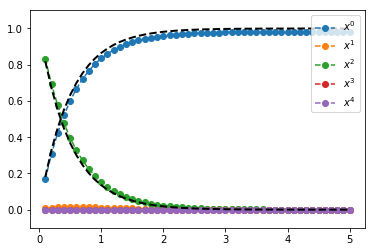

In [9]:
# Array of time instances:
lags = np.arange(1, 51, 1)
# Coefficient vector of x**2 with respect to monomial basis:
b = np.eye(n)[:, 2]
# Prepare output:
lag_coeffs = np.zeros((n, lags.shape[0]))
# Repeatedly apply Koopman matrix to coefficient vector:
for ii in range(lags.shape[0]):
    b = np.dot(K, b)
    lag_coeffs[:, ii] = b

# Plot coefficients of the variance as a function of t:
for ii in range(n):
    plt.plot(dt * m * lags, lag_coeffs[ii, :], "o--", label=r"$x^{%d}$"%ii)

plt.plot(dt * m * lags, np.exp(-2* dt * m * lags), "k--", linewidth=2)
plt.plot(dt * m * lags, (1 - np.exp(-2* dt * m * lags)), "k--", linewidth=2)
plt.ylim([-0.1, 1.1])
plt.legend(loc=1)

### Prediction 2
Let's add a control input to the above OU process, which allows to shift the mean value of the process. We will then use two Koopman models, learned at constant control inputs, to predict the system behaviour via the bi-linear ODE.

The controlled OU process is given by the SDE:
$$ dX_t = -(X_t - u(t)) dt + \sqrt{2}dB_t $$

In [10]:
# Adapt SDE integrator to accept time-dependent control input:
def Euler_Scheme_U(x0, u, dt, ntraj, m):
    # Prepare output:
    y = np.zeros((ntraj, m))
    y[:, 0] = x0
    # Initialize at x0:
    x = x0
    # Integrate:
    for kk in range(1, m):
        # Update:
        xn = x - dt * (x - u[kk-1]) + np.sqrt(2) * np.sqrt(dt)* np.random.randn(ntraj)
        # Update current state:
        y[:, kk] = xn
        x = xn
    return y

In [11]:
# Function for derivatives of the basis set:
def _Lpsi(x, u):
    m = x.shape[0]
    dpx = np.zeros((n, m))
    for ll in range(1, n):
        dpx[ll, :] = -(x - u) * ll * x**(ll-1) + ll * (ll - 1) * x**(ll-2)
    return dpx

In [12]:
# Choose two control values:
U = np.array([0.0, 1.0])
nu = U.shape[0]
# Data size for each Koopman model:
ntraj = 20000

In [13]:
# Learn Koopman models for each constant control:
L_array = []
for ii in range(nu):
    X = np.random.randn(ntraj) + U[ii]
    # Evaluate the basis set:
    PX = _psi(X)
    # Evaluate the derivatives of the basis set:
    dPX = _Lpsi(X, U[ii])
    # Compute generator matrix:
    Li = np.dot(scl.pinv(np.dot(PX, PX.T)), np.dot(PX, dPX.T))
    L_array.append(Li.copy())

In [14]:
# Choose sinusoidal control input:
Tmax = 10
t_vec = np.arange(0, Tmax, dt)

In [18]:
# Right-hand side for integration of bi-linear ODE:
def _uref(t):
    return np.cos(2*np.pi*t)

def _rhs(t, z):
    return (1 - _uref(t)) * np.dot(L_array[0].T, z) + _uref(t)*np.dot(L_array[1].T, z)

In [19]:
x0 = np.array([1.0])
z0 = _psi(x0)[:, 0]
# Integrate bi-linear ODE:
Z = odeint(_rhs, z0, t_vec, tfirst=True)

# Generate data:
#Y = Euler_Scheme_U(x0*np.ones(ntraj), _uref(t_vec), dt, ntraj, int(Tmax/dt))
Y = Euler_Scheme_U(x0*np.ones(ntraj), _uref(t_vec)*np.ones(int(Tmax/dt)), dt, ntraj, int(Tmax/dt))

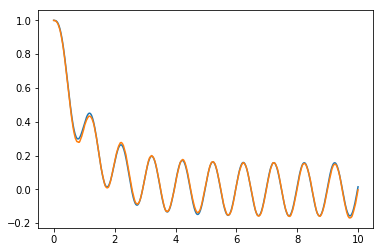

In [20]:
plt.plot(t_vec, Z[:, 1])
plt.plot(t_vec, np.mean(Y, axis=0))